In [1]:
# all imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import mutual_info_regression

In [2]:
# get work-data
data = pd.read_csv('data/raw_dataset/heart.csv')

# training data & target data
data_training = data.drop(columns=['output'])
target_data = data['output']

print('Dataset:')
print(f'Total length: {len(data)}')
print(f'Amount Attributes: {len(data.columns)} \n')
print('Details: ')
display(data.describe())

Dataset:
Total length: 303
Amount Attributes: 14 

Details: 


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


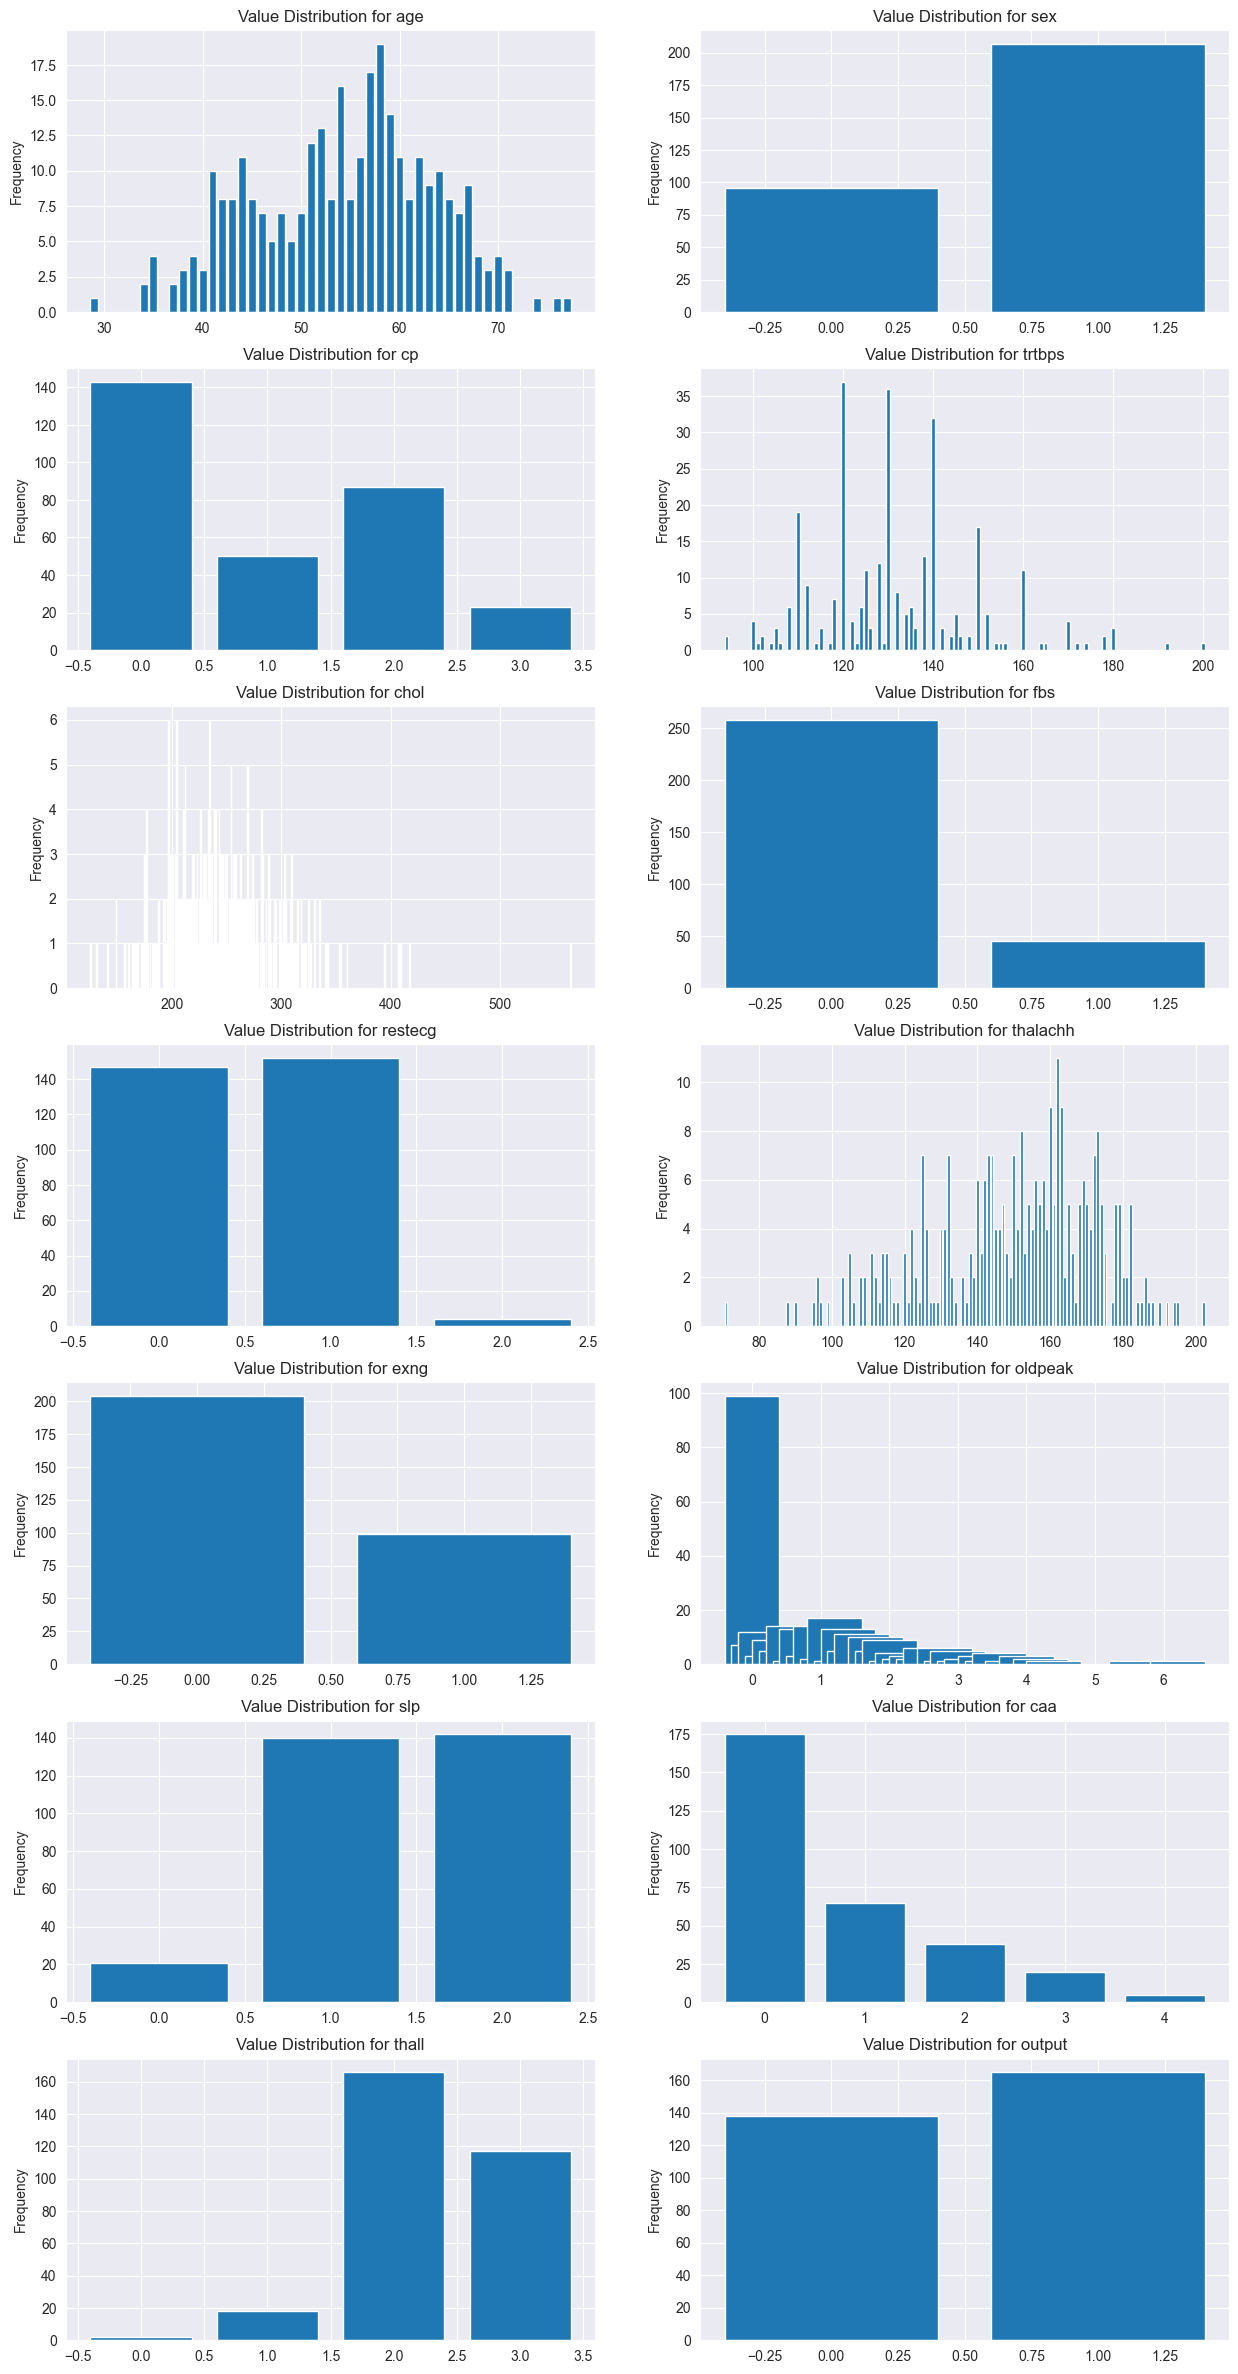

In [3]:
# plot distribution for each attribute

# figure
fig = plt.figure(figsize=(15,30))
    
fig_idx = 1

for c in data.columns:
    # add a sub plot to the figure
    axs = fig.add_subplot(7,2,fig_idx)
    
    # Get value counts for each class
    class_dist = data[c].value_counts().sort_index()

    # bar plot
    axs.bar(class_dist.index, class_dist.values)

    # Set the title
    axs.set_title(f'Value Distribution for {c}')

    # y-label
    axs.set_ylabel('Frequency')
    
    # counter
    fig_idx += 1

plt.show()

# Notes
We can see a lot of not perfect distributions for training.

## Age
- Normal Distribution
Low frequency for each datapoint

## Sex
- Boolean
Double as many male datapoints than women

## cp / chest pain
- 4 value distribution
value 0 has many more than the others

## trtbps / resting blood pressure (in mm Hg)
- random distribution
some outlayers

## chol
- normal distribution
some outlayers

## fbs
- boolean
value 0 many more samples than value 1

## restecg
- 3 values
value 2 has only few samples

## thalach / maximum heart rate achieved
- normal distribution
hard shift to the left

## exng
- boolean
value 0 has many more samples than value 1


# oldpeak
- weird dis
value 0 has a lot more samples than any other values


## slp
- 3 value distribution
value 0 has few samples

## caa
- 4 value distribution
lesser samples than the prev value

## thall
- ... distribution
outlayers

## output
- boolean
seems ok

# Data Preprocessing
## Normalization
For Classification making sense we need to normalize our dataset

In [4]:
# normalization of dataset
def normalize(data):
    data_norm = pd.DataFrame()
    
    for column in data.columns:
        # parameters needed
        c_min = min(data[column])
        c_max = max(data[column])
        
        data_norm[column] = data[column].apply(lambda x: (x - c_min) / (c_max -c_min))
    
    return data_norm
    
display(normalize(data_training))

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.708333,1.0,1.000000,0.481132,0.244292,1.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,1.0,0.032258,0.5,0.00,1.000000
299,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.0,0.193548,0.5,0.00,1.000000
300,0.812500,1.0,0.000000,0.471698,0.152968,1.0,0.5,0.534351,0.0,0.548387,0.5,0.50,1.000000
301,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,1.0,0.193548,0.5,0.25,1.000000


## Encoding
### OneHotEncoder
Valid approach as long as these variables are categorical and non-ordinal. It can help improve model performance by ensuring the categorical nature of these variables is appropriately represented. However, always be mindful of the increase in dimensionality and its potential impacts.

Interpretation for categorical attributes in data:
#### Chest Pain Type (cp):
- Categories: typical angina, atypical angina, non-anginal pain, and asymptomatic.
- Verdict: Non-ordinal.

#### Resting Electrocardiographic Results (restecg):
- Categories: normal, ST-T wave abnormality, probable or definite left ventricular hypertrophy by Estes' criteria.
- Verdict: Non-ordinal.

#### Slope of the Peak Exercise ST Segment (slp):
- Categories: flat, upsloping, downsloping.
- While there is a clear difference between these types, whether they constitute an 'order' can be subjective and depends on the context of the analysis.
- Verdict: ordinal (sometimes treated as non-ordinal)

#### Number of Major Vessels Colored by Fluoroscopy (caa):
- Count of major vessels seen in fluoroscopy.
- Verdict: Ordinal.

#### Thalassemia (thall):
- Severity can vary, but categories (e.g., normal, fixed defect, reversible defect) don't imply order.
- Verdict: Non-ordinal.


In [5]:
# encode dataset
def encode_data(data_training):
    encoder = preprocessing.OneHotEncoder()
    encoded = pd.DataFrame(encoder.fit_transform(data_training[['cp', 'restecg', 'slp', 'thall']]).toarray(), columns=encoder.get_feature_names_out(['cp', 'restecg', 'slp', 'thall']))
    
    data_training_prep = data_training.drop(columns=['cp', 'restecg', 'slp', 'thall'])
    data_training_prep = pd.concat([data_training_prep, encoded], axis=1)
    
    return data_training_prep


# normalize after encoding
data_training_prep = normalize(encode_data(data_training))

print('Encoded & normalized: ')
display(data_training_prep)

Encoded & normalized: 


,age,sex,trtbps,chol,fbs,thalachh,exng,oldpeak,caa,cp_0,...,restecg_0,restecg_1,restecg_2,slp_0,slp_1,slp_2,thall_0,thall_1,thall_2,thall_3
0,0.708333,1.0,0.481132,0.244292,1.0,0.603053,0.0,0.370968,0.00,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.166667,1.0,0.339623,0.283105,0.0,0.885496,0.0,0.564516,0.00,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.250000,0.0,0.339623,0.178082,0.0,0.770992,0.0,0.225806,0.00,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.562500,1.0,0.245283,0.251142,0.0,0.816794,0.0,0.129032,0.00,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.583333,0.0,0.245283,0.520548,0.0,0.702290,1.0,0.096774,0.00,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,0.583333,0.0,0.433962,0.262557,0.0,0.396947,1.0,0.032258,0.00,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
299,0.333333,1.0,0.150943,0.315068,0.0,0.465649,0.0,0.193548,0.00,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
300,0.812500,1.0,0.471698,0.152968,1.0,0.534351,0.0,0.548387,0.50,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
301,0.583333,1.0,0.339623,0.011416,0.0,0.335878,1.0,0.193548,0.25,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Needed functions from notebooks

In [6]:
# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Classification
## Train & Test Data

In [7]:
# train and test split
data_prep_train, data_prep_test, target_prep_train, target_prep_test = train_test_split(data_training_prep, target_data, test_size=0.3, random_state=42, stratify=target_data)

## Pipelines
### knn_pipeline
Everything as always

### naive bayes
To determine the best Naive Bayes estimator for this dataset, we have to consider the nature of the data:

- **Gaussian Naive Bayes:** Best for features with a normal distribution. It's suitable if, after normalization, the continuous features in the dataset (like age, trtbps - resting blood pressure, chol - cholesterol level, thalachh - maximum heart rate achieved, and oldpeak) follow a Gaussian distribution.

- **Multinomial Naive Bayes:** Suitable for discrete data. Given that we will encode several categorical features, if the encoded features dominate the feature space, a Multinomial Naive Bayes could be a good choice.

- **Bernoulli Naive Bayes:** Ideal for binary/boolean features. If the majority of features are binary after preprocessing, this could be a good choice.


-> We have a lot of classes with a normal distribution, but also many encoded features. Lets look at the dependency of each attribute to the result and determine if they are mainly encoded features or normalized ones.

Average Mutual Information:
Continuous Features: 0.059222537717572604
Categorical Features: 0.07764306054572323

Average Absolute Correlation:
Continuous Features: 0.17447534342459325
Categorical Features: 0.17735774187380454


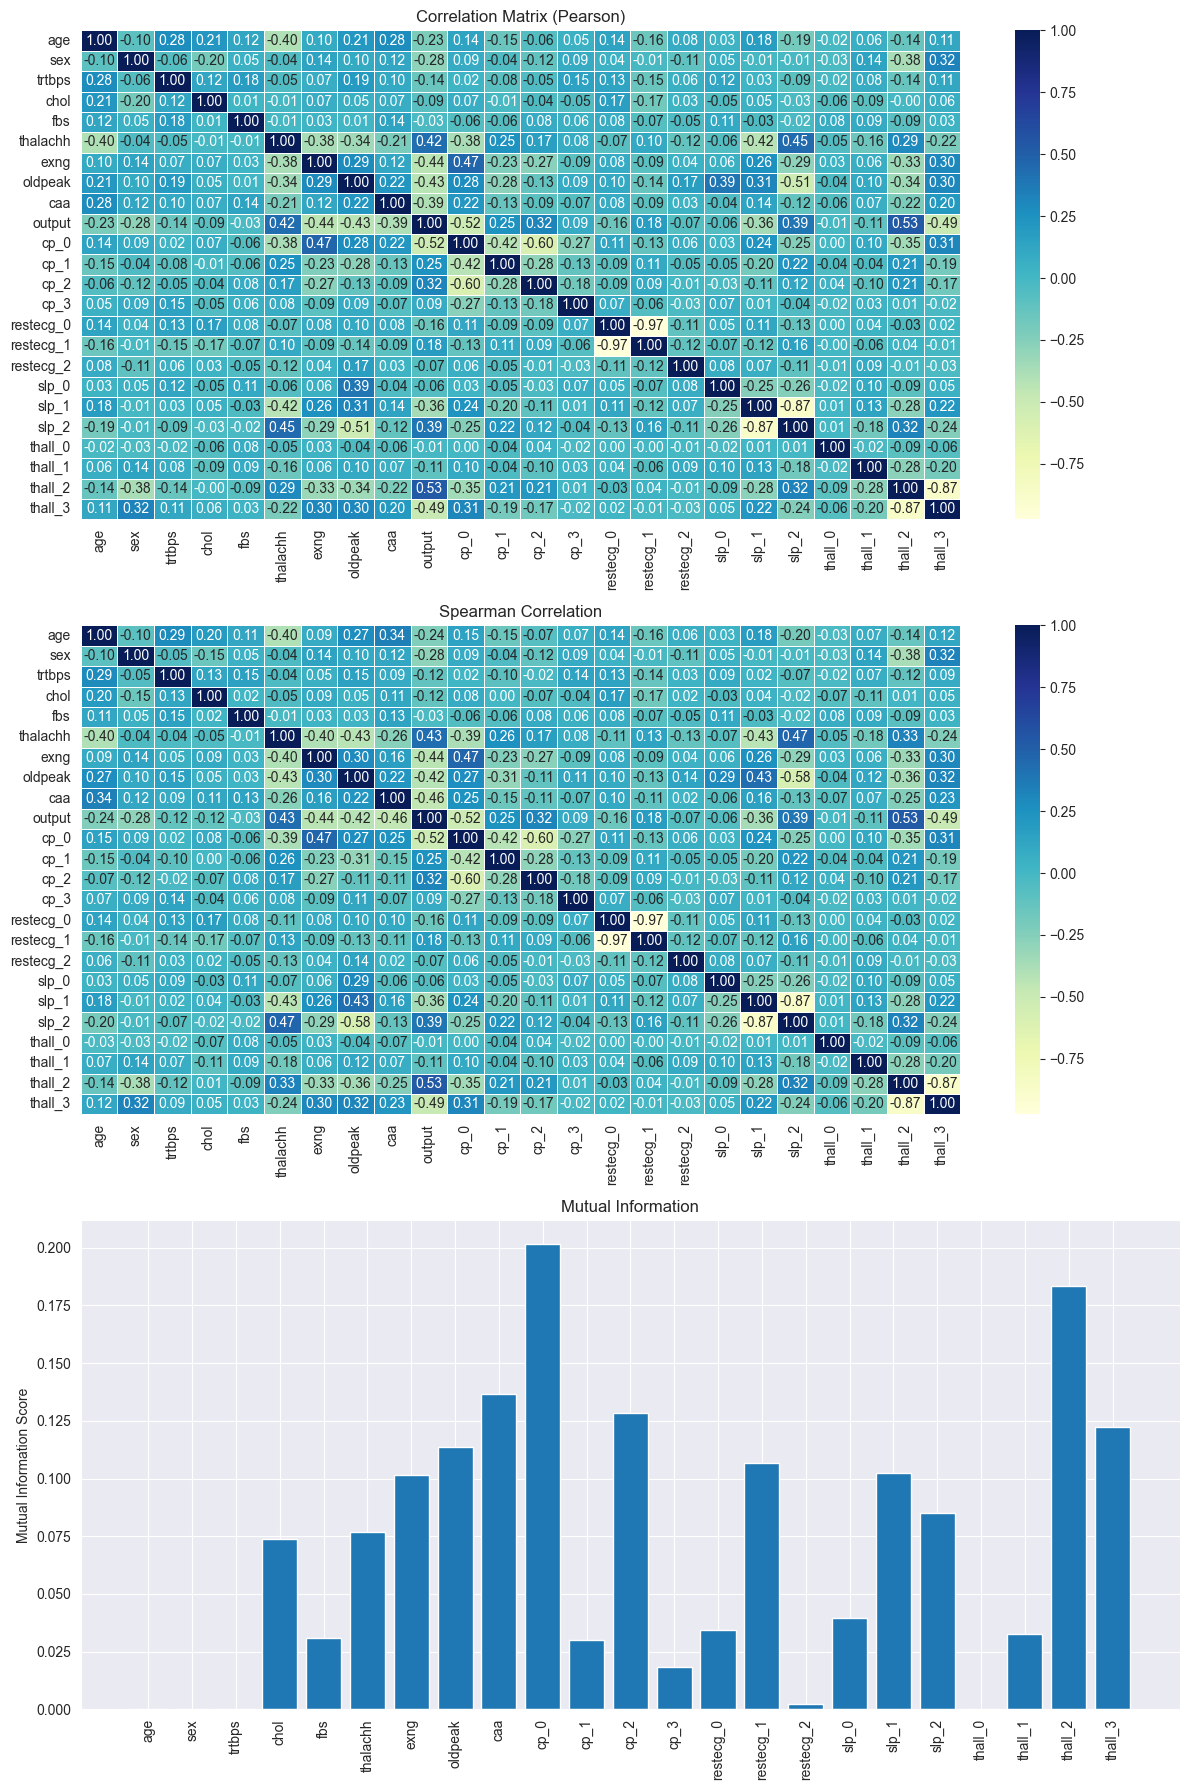

In [8]:
# Define continuous and categorical columns
continuous_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'caa', 'sex', 'fbs', 'exng']
categorical_cols = ['cp_0', 'cp_1', 'cp_2', 'cp_3', 'restecg_0', 'restecg_1', 'restecg_2', 'slp_0', 'slp_1', 'slp_2', 'thall_0', 'thall_1', 'thall_2', 'thall_3']

# Correlation matrix
corr_matrix = encode_data(data).corr()

# Spearman correlation
spearman_corr = encode_data(data).corr(method='spearman')

# Mutual Information
mutual_info = mutual_info_regression(encode_data(data_training), target_data)
mutual_info = pd.Series(mutual_info)
mutual_info.index = encode_data(data_training).columns

# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(3, 1, figsize=(12, 18))  # Adjusted figsize for better readability

# Plot correlation matrix
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[0])  # axs[0] refers to the first subplot
axs[0].set_title('Correlation Matrix (Pearson)')

# Plot Spearman correlation
sns.heatmap(spearman_corr, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu", 
            ax=axs[1])  # axs[1] refers to the second subplot
axs[1].set_title('Spearman Correlation')

# Plot Mutual Information
axs[2].bar(mutual_info.index, mutual_info)  # axs[2] refers to the third subplot
plt.xticks(rotation=90)
axs[2].set_ylabel('Mutual Information Score')
axs[2].set_title('Mutual Information')

plt.tight_layout()  # Adjust layout for better spacing

# Calculations for mutual information and correlations
avg_mi_continuous = mutual_info[continuous_cols].mean()
avg_mi_categorical = mutual_info[categorical_cols].mean()

avg_corr_continuous = corr_matrix[continuous_cols].abs().mean().mean()
avg_corr_categorical = corr_matrix[categorical_cols].abs().mean().mean()

# Printing the results
print("Average Mutual Information:")
print("Continuous Features:", avg_mi_continuous)
print("Categorical Features:", avg_mi_categorical)
print("\nAverage Absolute Correlation:")
print("Continuous Features:", avg_corr_continuous)
print("Categorical Features:", avg_corr_categorical)

plt.show()

#### Interpretation of correlation
No big difference: Use both estimators

### Implementation of Pipelines

#### K-nearest Neighbour

Parameters:
- n_neighbors: Any = 5,
- weights: Any = "uniform",
- algorithm: Any = "auto",
- leaf_size: Any = 30,
- p: Any = 2,
- metric: Any = "minkowski",
- metric_params: Any = None,
- n_jobs: Any = None


In [14]:
pipelines = {}


# knn pipeline
knn_pipeline = Pipeline([ 
    # ('preprocessing', preprocessor), 
    # ('balancing', RandomOverSampler()), # No over sampler
    ('estimator', KNeighborsClassifier())
    ])

# knn parameter grid
knn_pipeline_param_grid = {
    'estimator__n_neighbors': list(range(1, 31)),  # Wider range for number of neighbors
    'estimator__weights': ['uniform', 'distance'],  # Whether to weight neighbors equally or by distance
    'estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algorithm used to compute nearest neighbors
    'estimator__leaf_size': [10, 30, 50, 70, 90],  # Leaf size passed to BallTree or KDTree
    'estimator__p': [1, 2]  # Power parameter for the Minkowski metric
}

pipelines['knn'] = [knn_pipeline, knn_pipeline_param_grid]


# Naive Bayes pipeline GaussianNB
nb_gau_pipeline = Pipeline([ 
    # ('preprocessing', StandardScaler()), # Uncomment and adjust if preprocessing is required
    # ('balancing', RandomOverSampler()), # Uncomment if over-sampling is required
    ('estimator', GaussianNB())
])

# GaussianNB parameter grid
nb_gau_pipeline_param_grid = {
    'estimator__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
}

pipelines['nb_gaussian'] = [nb_gau_pipeline, nb_gau_pipeline_param_grid]


# Naive Bayes pipeline MultinomialNB
nb_multi_pipeline = Pipeline([ 
    # ('preprocessing', StandardScaler()), # Uncomment and adjust if preprocessing is required
    # ('balancing', RandomOverSampler()), # Uncomment if over-sampling is required
    ('estimator', MultinomialNB())
])

# MultinomialNB parameter grid
nb_multi_pipeline_param_grid = {
    'estimator__alpha': [0.0, 0.5, 1.0, 1.5, 2.0],  # Smoothing parameter
}

pipelines['nb_multinomial'] = [nb_multi_pipeline, nb_multi_pipeline_param_grid]


# cross val
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

## Asumptions for optimizing
In our we try to predict an heart attack.
So it is bad when we predict no and the real value is true
    -> recall 0 high
    

In our heart attack prediction project, it's crucial to minimize false negatives (predicting 'no heart attack' when there is one), as this error could have serious health implications. In contrast, false positives (predicting a heart attack when there isn't one) may lead to unnecessary tests or treatments but are generally less harmful than missing an actual heart attack.


| Actual \ Predicted | No Heart Attack (0) | Heart Attack (1) |
|-------------------|---------------------|------------------|
| No Heart Attack (0) | True Negative (TN) | False Positive (FP) |
| Heart Attack (1)   | False Negative (FN) | True Positive (TP) |

Let's denote the cost of a false negative as \( C_{FN} \) and the cost of a false positive as \( C_{FP} \). The cost of true positives \( C_{TP} \) and true negatives \( C_{TN} \) can be set to zero or a lower value, as these are correct predictions. The total cost of the confusion matrix can then be calculated as:

\[ \text{Total Cost} = C_{FN} \times \text{FN} + C_{FP} \times \text{FP} \]

Given the critical nature of missing a heart attack, \( C_{FN} \) should be significantly higher than \( C_{FP} \). For example, you might set \( C_{FN} = 10 \) and \( C_{FP} = 1 \).


In [15]:
# cost function
def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred)
    cost = cm[0][1] * 100 + cm[1][0] * 1
    return cost

# create a scorer for the grid search
cost_score = make_scorer(cost_function, greater_is_better=False)

In [ ]:
for i in [4, 10, 23]: # range(29, 30):
    # Set number of neighbors
    knn_pipeline.set_params(estimator__n_neighbors=i, estimator__algorithm='auto', estimator__leaf_size=10, estimator__p=1, estimator__weights='uniform')
    
    # Training
    knn_pipeline.fit(data_prep_train, target_prep_train)
    
    # Prediction
    prediction = knn_pipeline.predict(data_prep_test)
    
    # Accuracy and report
    print("k= {} acc: {}".format(i, accuracy_score(target_prep_test, prediction)))
    # costs
    cost = cost_function(target_prep_test, prediction)
    acc = accuracy_score(target_prep_test, prediction)

    print("Decision Tree with accuracy of {} and cost {}".format(acc, cost))
    print(classification_report(target_prep_test, prediction))
    
    # Confusion Matrix
    classes = np.unique(np.concatenate((target_prep_test, prediction)))  # Ensure all labels are included
    cnf_matrix = confusion_matrix(target_prep_test, prediction, labels=classes)
    np.set_printoptions(precision=2)

    # Plotting
    plt.figure()  # Create a new figure for each iteration
    plot_confusion_matrix(cnf_matrix, classes=classes, title=f'{i}-NN Classifier')
    plt.show()  # Show the plot for each iteration
     i: 4, 10 ->   recall 0 = 0.86

## Gridsearch


 
 

-------------------------------------
Grid search for knn
-------------------------------------
Optimised knn with accuracy of 0.7887788778877888 and cost 2143


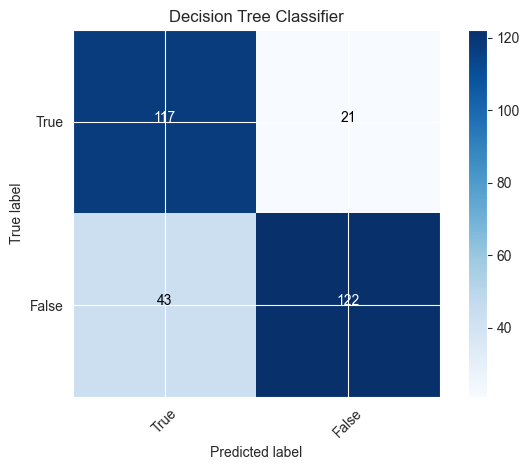

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       138
           1       0.85      0.74      0.79       165

    accuracy                           0.79       303
   macro avg       0.79      0.79      0.79       303
weighted avg       0.80      0.79      0.79       303
Best Parameters:  {'estimator__algorithm': 'auto', 'estimator__leaf_size': 10, 'estimator__n_neighbors': 2, 'estimator__p': 1, 'estimator__weights': 'uniform'}
Best Score:  -103.2

 
 

-------------------------------------
Grid search for nb_gaussian
-------------------------------------
Optimised nb_gaussian with accuracy of 0.7986798679867987 and cost 3130


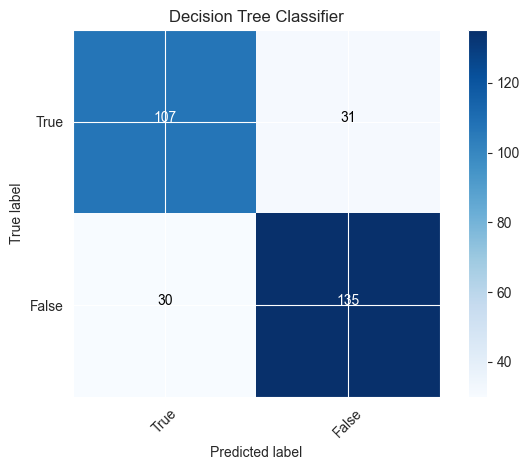

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       138
           1       0.81      0.82      0.82       165

    accuracy                           0.80       303
   macro avg       0.80      0.80      0.80       303
weighted avg       0.80      0.80      0.80       303
Best Parameters:  {'estimator__var_smoothing': 1e-09}
Best Score:  -84.7

 
 

-------------------------------------
Grid search for nb_multinomial
-------------------------------------
Optimised nb_multinomial with accuracy of 0.8151815181518152 and cost 2234


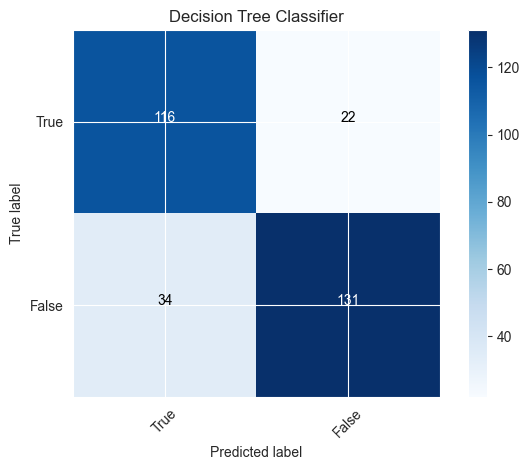

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       138
           1       0.86      0.79      0.82       165

    accuracy                           0.82       303
   macro avg       0.81      0.82      0.81       303
weighted avg       0.82      0.82      0.82       303


C:\Users\leanf\PycharmProjects\sync\ml_group4_heart_attack\venv\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\leanf\PycharmProjects\sync\ml_group4_heart_attack\venv\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
C:\Users\leanf\PycharmProjects\sync\ml_group4_heart_attack\venv\Lib\site-packages\sklearn\naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
C:\Users\leanf\PycharmProjects\sync\ml_group4_heart_attack\venv\Lib\site-packages\sklearn\naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e

Best Parameters:  {'estimator__alpha': 1.0}
Best Score:  -131.7


In [16]:
for key, value in pipelines.items():
    print('\n \n \n')
    print('-------------------------------------')
    print(f'Grid search for {key}')
    print('-------------------------------------')
    # Create grid search object with specified parameter grid
    grid_search = GridSearchCV(value[0], value[1], cv=stratified_10_fold_cv, scoring=cost_score)
    
    # cross-validate
    prediction = cross_val_predict(grid_search, data_training_prep, target_data, cv=stratified_10_fold_cv, n_jobs=-1)
    
    # calculate costs
    cm = confusion_matrix(target_data, prediction)
    cost = cost_function(target_data, prediction)
    acc = accuracy_score(target_data, prediction)
    
    print("Optimised {} with accuracy of {} and cost {}".format(key, acc, cost))
    plot_confusion_matrix(cm, classes=['True', 'False'], title='Decision Tree Classifier')
    plt.show()
    print(classification_report(target_data, prediction))
    
    # Fit grid search to the data
    grid_search.fit(data_prep_train, target_prep_train)
    
    # Best parameters
    best_parameters = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print("Best Parameters: ", best_parameters)
    print("Best Score: ", best_score)